# Python version of radiative kernels
V. Cooper (2023)
- 0) Before running, make timeseries on std pressure levels
- 1) Compute climatology
- 2) Horizontal regridding
- 3) Feedback calcs converted from Pendergrass public scripts

Before running these scripts, postprocess the 3D fields into 
timeseries that are on pressure levels (not hybrid-sigma levels as 
in the native output). After timeseries files are prepared, they can
be loaded here to make a climatology, regrid onto kernel grid, then compute feedbacks.

Note: if changing the pressure levels from CMIP to something else,
- don't run "ncl scripts/calcp.ncl"
- run "ncl tools/calcdp_plev.ncl"
- run "ncl tools/t_kernel_to_plev.ncl"
- run "ncl tools/q_kernel_to_plev.ncl"

Note: the following 2 scripts are replaced by the timeseries creation, 
which already puts fields on pressure levels. No need to do these:
- don't run "ncl tools/convert_base_to_plevs.ncl"
- don't run "ncl tools/convert_change_to_plevs.ncl"

In [1]:
# import warnings
# warnings.filterwarnings('ignore')

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
# import xesmf as xe
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import copy
import pandas as pd
import cmocean as cmo
from cartopy.util import add_cyclic_point
import seaborn as sns
%matplotlib inline

import xesmf as xe

# Compute climatology

In [2]:
## these are the dummy files for format and grid matching
path = './'

## these are demodata, will be replaced later after we match
## the file formatting
basefields = xr.open_dataset(path +'demodata/'+ 'basefields.nc~')
changefields = xr.open_dataset(path +'demodata/'+ 'changefields.nc~')
PSdemo = xr.open_dataset(path + 'kernels/PS.nc')
pdiff = xr.open_dataset(path + 'dp_plev.nc')
gw = xr.open_dataset(path +'kernels/'+ 't.kernel.nc').gw

varlist = ['FSDS','FSNS','Q','T','FLNS',
           'FLNSC','FLNT','FLNTC','FSNSC',
           'FSNT','FSNTC','PS'] #'TS' will be loaded by default
## WATCH OUT YOU ACTUALLY NEED FSDSC for clear-sky linearity test

### Select cases here

In [51]:
path = '/glade/scratch/vcooper/processed/'

External_switch = False ## False for CAM, True for GFDL
strat_mask = False  ## True is default which masks stratosphere changes
cs_linearity_test = False ## True only if doing clear-sky linearity test

## SELECT BASECASE
# basecase = 'f2000climo_f19_f19_holo_3_23_23' ## CAM6

basecase = 'f.e1221.F_2000_CAM5.f19_f19.LGMRholo.002' ## CAM5

# basecase = 'f.e1221.F_2000.f19_f19.LGMRholo.002' ## CAM4
#basecase = 'f.e1221.F_2000.f19_f19.LGMRholo.003' ## CAM4 v3

## SELECT CHANGECASE
# case = 'f2000climo_f19_f19_2xco2by05_05'
# case = 'f2000climo_f19_f19_2xc02_05'
# case = 'f2000climo_f19_f19_pattern_05'
# case = 'f2000climo_f19_f19_LGMRby05_05_fixed'

# case = 'f.e1221.F_2000_CAM5.f19_f19.longrunmip-0p5.002'
# case = 'f.e1221.F_2000_CAM5.f19_f19.longrunmip.002'
# case = 'f.e1221.F_2000_CAM5.f19_f19.LGMR-0p5.002'
case = 'f.e1221.F_2000_CAM5.f19_f19.LGMRlgm.001'
# case = 'f.e1221.F_2000_CAM5.f19_f19.lgmDA.002'
# case = 'f.e1221.F_2000_CAM5.f19_f19.lgmDA-0p5.002'
# case = 'f.e1221.F_2000_CAM5.f19_f19.amrhein.002.1'
# case = 'f.e1221.F_2000_CAM5.f19_f19.amrhein-0p5.002'
# case = 'f.e1221.F_2000_CAM5.f19_f19.annan-seasbyamr.002.1'
# case = 'f.e1221.F_2000_CAM5.f19_f19.annan-0p5.002'

# case = 'f.e1221.F_2000.f19_f19.longrunmip-0p5.002'
# case = 'f.e1221.F_2000.f19_f19.longrunmip2x.002'
# case = 'f.e1221.F_2000.f19_f19.LGMR-0p5.002'
# case = 'f.e1221.F_2000.f19_f19.LGMRlgm.001'
# case = 'f.e1221.F_2000.f19_f19.lgmDA.002'
# case = 'f.e1221.F_2000.f19_f19.lgmDA-0p5.002'
# case = 'f.e1221.F_2000.f19_f19.amrhein.002.1'
# case = 'f.e1221.F_2000.f19_f19.amrhein-0p5.002'
# case = 'f.e1221.F_2000.f19_f19.annan-seasbyamr.002.1'
# case = 'f.e1221.F_2000.f19_f19.annan-0p5.002'

changecase = case

In [4]:
## load in the full timeseries
fname = basecase + '.cam.h0.tseries_interp.nc'
basecam_out = xr.open_dataset(path + basecase +'/'+fname)
fname = case + '.cam.h0.tseries_interp.nc'
cam_out = xr.open_dataset(path + case +'/'+fname)

In [5]:
## TEMPORARY FSDSC FIX (this variable was not originally included)
tpath = '/glade/scratch/vcooper/archive/' + case + '/atm/proc/tseries/month_1/'
fname = case + '.cam.h0.FSDSC.000101-003012.nc'
FSDSC = xr.open_dataset(tpath + fname).sel(
    time=slice('0006-01-02','0031-01-01')).FSDSC
cam_out['FSDSC'] = (['time','lat','lon'], FSDSC.values)

tpath = '/glade/scratch/vcooper/archive/' + basecase + '/atm/proc/tseries/month_1/'
fname = basecase + '.cam.h0.FSDSC.000101-003012.nc'
baseFSDSC = xr.open_dataset(tpath + fname).sel(
    time=slice('0006-01-02','0031-01-01')).FSDSC
basecam_out['FSDSC'] = (['time','lat','lon'], baseFSDSC.values)

In [6]:
## this is stupid code to fix the months
init_bound = np.array(xr.cftime_range(start="0006", periods=1, freq="MS", calendar="noleap")[0])
dumtime = np.hstack([init_bound,cam_out.time.values])
newtime = dumtime[0:-1]
cam_out['time'] = newtime
basecam_out['time'] = newtime

cam_climo = cam_out#.groupby('time.month').mean()
basecam_climo = basecam_out#.groupby('time.month').mean()

if External_switch == False:
    cam_climo = cam_out.groupby('time.month').mean()
    basecam_climo = basecam_out.groupby('time.month').mean()

In [18]:
## quick check of climo
lpath = '/glade/scratch/vcooper/processed/f.e1221.F_2000_CAM5.f19_f19.longrunmip-0p5.002/'
lname = 'o2.nc'
cdo_climo2 = xr.open_dataset(lpath + lname)

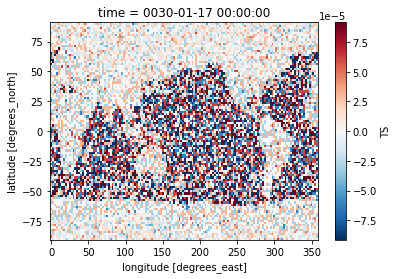

In [21]:
(cdo_climo2.TS[0] - cam_climo.TS[0].values).plot()

In [8]:
### Change some fields to match demodata
if External_switch == False:
    basecase = basecam_climo.rename(
        {'month':'time','T':'temp','TS':'ts','lev':'lev_p'})

    changecase = cam_climo.rename(
        {'month':'time','T':'temp','TS':'ts','lev':'lev_p'})

# Option to replace CAM data with external model

In [9]:
if External_switch == True:
    ## GFDL
    path = '/glade/scratch/vcooper/processed/'

    ## already in climatology form
    basecase = xr.open_dataset(path + 'gfdl_holo/gfdl_holo.nc').rename(
            {'T':'temp','TS':'ts','lev':'lev_p','swdn_sfc_clr':'FSDSC'})

    changecase = xr.open_dataset(path + 'gfdl_2xCO2/gfdl_2xCO2.nc').rename(
            {'T':'temp','TS':'ts','lev':'lev_p','swdn_sfc_clr':'FSDSC'})
    # changecase = xr.open_dataset(path + 'gfdl_lgm/gfdl_lgm.nc').rename(
    #         {'T':'temp','TS':'ts','lev':'lev_p','swdn_sfc_clr':'FSDSC'})
    
    ## shortcut to select only the kernel CMIP pressure levels
    basecase = basecase.sel(lev_p=pdiff.plev.values/100)
    changecase = changecase.sel(lev_p=pdiff.plev.values/100)

# Regrid horizontal fields to match kernel 1 degree resolution

In [10]:
diff = changecase - basecase

In [11]:
## xesmf issue with date and datesec, avoiding it here:
regridvars = ['temp',
                         # 'date',
                         # 'datesec',
                         'Q',
                         'PS',
                         'ts',
                         'FSDS',
                         'FSNS',
                         'FLNS',
                         'FLNSC',
                         'FLNT',
                         'FLNTC',
                         'FSNSC',
                         'FSNT',
                         'FSNTC']

if (cs_linearity_test == True):
    regridvars = np.append(regridvars, 'FSDSC')

In [12]:
newgrid = basefields.ts[0].to_dataset()
newgrid = basefields

data_for_regridding = basecase.ts[0].to_dataset()
data_for_regridding = basecase

if External_switch == False:
    filename_wts = 'bilinear_2deg_to_1deg.nc'
else:
    filename_wts = 'external_regrid_wts.nc'

regridder = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',
                         periodic=True,
                         # extrap_method='inverse_dist',extrap_num_src_pnts=8,
                         filename=filename_wts,
                         reuse_weights=True)

base_regrid = regridder(basecase[regridvars])
diff_regrid = regridder(diff[regridvars])

## avoiding xesmf issue
if External_switch == False:
    base_regrid['date'] = basecase['date']
    base_regrid['datesec'] = basecase['datesec']

    diff_regrid['date'] = diff['date']
    diff_regrid['datesec'] = diff['datesec']

Reuse existing file: bilinear_2deg_to_1deg.nc
using dimensions ('lat', 'lon') from data variable temp as the horizontal dimensions for this dataset.


/glade/u/home/vcooper/miniconda3/envs/plato/lib/python3.8/site-packages/xesmf/frontend.py:477: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


using dimensions ('lat', 'lon') from data variable temp as the horizontal dimensions for this dataset.


In [13]:
## add some variables to file that seem to not change
## note: pdiffs are constant because they are diff between 
## the native kernels and the CMIP5 standard levels
base_regrid['plev'] = base_regrid.lev_p * 100
base_regrid['gw'] = ('lat', gw.values)
base_regrid['pdiff'] = (['time','lev_p','lat','lon'], pdiff.dp.values)

## note that pdiff is the same for the changefields
diff_regrid['plev'] = diff_regrid.lev_p * 100
diff_regrid['gw'] = ('lat', gw.values)
diff_regrid['pdiff'] = (['time','lev_p','lat','lon'], pdiff.dp.values)

In [14]:
## OLD VERSION: Save these files
# ## save data into correct directory
# # finaldir = '/glade/work/vcooper/kernels/cam5-kernels/'
# finaldir = '/glade/work/vcooper/kernels/2023_cam5/cam5-kernels/'
# fname = 'basefields.plev.nc'
# base_regrid.to_netcdf(finaldir + fname)
# fname = 'changefields.plev.nc'
# diff_regrid.to_netcdf(finaldir + fname)

# ## save here too since 2D variables use this file
# # finaldir = '/glade/work/vcooper/kernels/cam5-kernels/demodata/'
# finaldir = '/glade/work/vcooper/kernels/2023_cam5/cam5-kernels/demodata/'
# fname = 'basefields.nc'
# base_regrid.to_netcdf(finaldir + fname)
# fname = 'changefields.nc'
# diff_regrid.to_netcdf(finaldir + fname)
# print('done')

In [15]:
## option to calculate only clear-sky
## accomplished by making all-sky fields equal the clear-sky fields
if (cs_linearity_test == True):
    diff_regrid['FLNT'] = diff_regrid['FLNTC']
    diff_regrid['FSNT'] = diff_regrid['FSNTC']
    diff_regrid['FLNS'] = diff_regrid['FLNSC']
    diff_regrid['FSNS'] = diff_regrid['FSNSC']
    
    base_regrid['FLNT'] = base_regrid['FLNTC']
    base_regrid['FSNT'] = base_regrid['FSNTC']
    base_regrid['FLNS'] = base_regrid['FLNSC']
    base_regrid['FSNS'] = base_regrid['FSNSC']
    
    diff_regrid['FSDS'] = diff_regrid['FSDSC']
    base_regrid['FSDS'] = base_regrid['FSDSC']

# Calculate all feedbacks
- This portion is adapted from Pendergrass scripts

In [16]:
# File with the changes in climate: (ts, temp) (TS,T,Q)
varlist2d = ['ts','gw','FSNS', 'FSDS', 'FSNT']

# changefile=xr.open_dataset('./demodata/changefields.nc')[varlist2d]
# changefile3d=xr.open_dataset('./changefields.plev.nc')
# basefile=xr.open_dataset('./demodata/basefields.nc')[varlist2d]
# basefile3d=xr.open_dataset('./basefields.plev.nc')

changefile=diff_regrid#[varlist2d]
changefile3d=diff_regrid
basefile=base_regrid#[varlist2d]
basefile3d=base_regrid


###################

## Read air temperature kernel 
# ta_kernel_hybrid=ncread('kernels/t.kernel.nc','FLNT');
ta_kernel=xr.open_dataset('t.kernel.plev.nc')

## VTC add section to read in pressure levels
p_Pa=ta_kernel.plev
p_hPa=ta_kernel.lev_p 

## this must be generated by calcdp_plev.ncl script
pdiff=xr.open_dataset('dp_plev.nc').dp/100

# p=repmat(permute(repmat(p_hPa,[1 12]),[3 4 1 2]),[288 192 1 1]);
p = p_hPa.values[np.newaxis, :, np.newaxis, np.newaxis] * np.ones(ta_kernel.FLNT.shape)

In [17]:
###################

## Read in coordinate info
lat=xr.open_dataset('./kernels/PS.nc').lat
lon=xr.open_dataset('./kernels/PS.nc').lon
gw=xr.open_dataset('./kernels/t.kernel.nc').gw ## Gaussian weights for CESMgrid
# lev=ncread('kernels/t.kernel.nc','lev'); ## dont need

## Make an area weighting matrix
weight=np.tile(gw.values[:,np.newaxis], len(lon))
weight=weight/np.nansum(weight)
# print(weight.sum())

## Read surface temperature change
dts=changefile.ts

## Calculate the change in global mean surface temperature
dts_globalmean= (dts * weight).sum(dim=('lat','lon')).mean(dim='time')
print('Global mean dTS: ', dts_globalmean.values)
                 

Global mean dTS:  -5.006422281463379


In [18]:
## Temperature feedback calculation

## Read TOA Longwave surface temperature kernel
ts_kernel=xr.open_dataset('./kernels/ts.kernel.nc').FLNT
if (cs_linearity_test == True):
    ts_kernel=xr.open_dataset('./kernels/ts.kernel.nc').FLNTC

## Multiply monthly mean TS change by the TS kernels (function of
## lat, lon, month) (units W/m2)
dLW_ts=ts_kernel * dts
#dLW_ts.mean(dim='time').plot()

## Read air temperature change [lon,lat,level,month]
dta=changefile3d.temp


In [19]:
## Non-pressure level version:
## Read midpoint pressure for each grid cell (lat,lon,level,month), [Pa]
## VTC adjusted this above to be pressure levels
## p=ncread('p_sigma.nc','pmid')/100; %[hPa] 

In [20]:
## Crude tropopause estimate: 100 hPa in the tropics, lowering with
## cosine to 300 hPa at the poles.
x=np.cos(np.deg2rad(lat))
p_tropopause_zonalmean=300-200*x
## VTC
##p_tropopause= ...
##    repmat(permute(repmat(permute(repmat(p_tropopause_zonalmean', ...
##                                         [length(lon) 1]),[1 2 3]),[1 ...
##                    1 length(lev)]),[1 2 3 4]),[1 1 1 12]);
p_tropopause = p_tropopause_zonalmean.values[
    np.newaxis, np.newaxis,:, np.newaxis] * np.ones(ta_kernel.FLNT.shape)
p_tropopause = xr.DataArray(p_tropopause,dims=changefile3d.dims, coords = changefile3d.coords)

if (strat_mask == False):
    ## True is default, but for cases with no forcing,
    ## maybe we don't want to mask these bc they are part of feedback
    ## make tropopause be at 0 hPa so that nothing is masked
    p_tropopause -= p_tropopause

In [21]:
## Set the temperature change to zero in the stratosphere (mask out stratosphere)
dta=xr.where(p>=p_tropopause, dta, np.nan)

## Convolve air temperature kernel with air temperature change
## VTC
## dLW_ta=squeeze(sum(ta_kernel.*dta,3));
dLW_ta=ta_kernel.FLNT * dta.values * pdiff.values
if (cs_linearity_test == True):
    dLW_ta=ta_kernel.FLNTC * dta.values * pdiff.values

In [22]:
## Add the surface and air temperature response; Take the annual
## average and global area average 
dLW_t_globalmean = -(
    (dLW_ta.sum(dim='plev') + dLW_ts).mean(dim='time') * weight).sum()

## Divide by the global annual mean surface warming (units: W/m2/K)
t_feedback=dLW_t_globalmean / dts_globalmean

print('Temperature feedback: ', str(t_feedback.values), ' W m^-2 K^-1')

Temperature feedback:  -3.2444181320747503  W m^-2 K^-1


# Albedo Feedback

In [23]:
## Collect surface shortwave radiation fields to calculate albedo.
## Alternatively, you might already have the change in albedo - that
## would work too.
SW_sfc_net_1=basefile.FSNS
SW_sfc_down_1=basefile.FSDS
SW_sfc_net_2=changefile.FSNS+SW_sfc_net_1
SW_sfc_down_2=changefile.FSDS+SW_sfc_down_1

alb1= 1 - SW_sfc_net_1/SW_sfc_down_1
alb1 = xr.where(np.isnan(alb1), 0, alb1)

alb2= 1 - SW_sfc_net_2/SW_sfc_down_2
alb2 = xr.where(np.isnan(alb2), 0, alb2)

dalb=(alb2-alb1)*100

alb_kernel = xr.open_dataset('./kernels/alb.kernel.nc').FSNT
if (cs_linearity_test == True):
    alb_kernel = xr.open_dataset('./kernels/alb.kernel.nc').FSNTC
    
dSW_alb = alb_kernel * dalb


In [24]:
## average and global area average 
dSW_alb_globalmean = (dSW_alb.mean(dim='time') * weight).sum()
alb_feedback = dSW_alb_globalmean / dts_globalmean

print('Surf. albedo feedback: ', str(alb_feedback.values), ' W m^-2 K^-1')

Surf. albedo feedback:  0.5576608388467523  W m^-2 K^-1


# Water vapor feedback

In [25]:
## Calculate the change in moisture per degree warming at constant relative humidity. 
q1=basefile3d.Q
t1=basefile3d.temp

In [26]:
## addpath scripts/
## VTC script for
def calcsatspechum(t_in, p_in):
    ## T is temperature, P is pressure in hPa 

    ## Formulae from Buck (1981):
    es = (1.0007+(3.46e-6 * p_in)) * 6.1121 * (
        np.exp(17.502*(t_in - 273.15) / (240.97+(t_in - 273.15))))
    
    wsl = 0.622 * es / (p_in - es) ## saturation mixing ratio wrt liquid water (g/kg)
    
    es = (1.0003 + ( 4.18e-6 * p_in)) * 6.1115 * (
        np.exp(22.452 * (t_in - 273.15) / (272.55 + (t_in - 273.15))))
    
    wsi = 0.622 * es / (p - es) ## saturation mixing ratio wrt ice (g/kg)
    
    ws = wsl
    
    ws = xr.where(t_in < 273.15, wsi, ws)
    
    qs = ws / (1+ws) ## saturation specific humidity, g/kg
    return(qs)


In [27]:
qs1 = calcsatspechum(t1,p) #g/kg
qs2 = calcsatspechum(t1+dta,p) #g/kg
dqsdt = (qs2 - qs1) / dta
rh = q1 / qs1
dqdt = rh * dqsdt

## Read kernels
q_LW_kernel = xr.open_dataset('q.kernel.plev.nc').FLNT
q_SW_kernel = xr.open_dataset('q.kernel.plev.nc').FSNT
if (cs_linearity_test == True):
    q_LW_kernel = xr.open_dataset('q.kernel.plev.nc').FLNTC
    q_SW_kernel = xr.open_dataset('q.kernel.plev.nc').FSNTC

## Normalize kernels by the change in moisture for 1 K warming at
## constant RH
q_LW_kernel = q_LW_kernel.values / dqdt;
q_SW_kernel = q_SW_kernel.values / dqdt;

## Read the change in moisture
dq = changefile3d.Q

In [28]:
## Set the moisture change to zero in the stratosphere (mask out stratosphere)
dq = xr.where(p>=p_tropopause, dq, np.nan)

In [29]:
## Convolve moisture kernel with change in moisture
dLW_q = q_LW_kernel * dq.values * pdiff.values
dSW_q = q_SW_kernel * dq.values * pdiff.values

In [30]:
## Add the LW and SW responses. Note the sign convention difference
## between LW and SW!
dR_q_globalmean = (
    (-dLW_q + dSW_q).sum(dim='lev_p').mean(dim='time') * weight).sum()

## Divide by the global annual mean surface warming (units: W/m2/K)
q_feedback = dR_q_globalmean / dts_globalmean

print('Water vapor feedback: ', str(q_feedback.values), ' W m^-2 K^-1')


Water vapor feedback:  1.3186106209644146  W m^-2 K^-1


# WV with log of Q

In [31]:
## Calculate the change in moisture per degree warming at constant relative humidity. 
## Run the accompanying NCL script with your input files, or
## implement here.                                                             

In [32]:
q0 = q1 ## AP used q1 for this above #basefile3d.Q #kg/kg 

## all of these are set above
#t1 = basefile3d.temp set above
#dta = changefile3d.temp ## set above
#qs1 = calcsatspechum(t1,p); % g/kg
#qs2 = calcsatspechum(t1+dta,p); % g/kg
#dqsdt = (qs2 - qs1)./dta;

## slightly different from above
rh = 1000*q0 / qs1
dqdt = rh * dqsdt ## assume constant RH
dlogqdt= dqdt / (1000 * q0) ## convert denominator to g/kg

## Re-read kernels, 
## normalize by the change in moisture for 1 K warming at
## constant RH using log Q
q_LW_kernel = xr.open_dataset('q.kernel.plev.nc').FLNT.values
if (cs_linearity_test == True):
    q_LW_kernel = xr.open_dataset('q.kernel.plev.nc').FLNTC.values
logq_LW_kernel = q_LW_kernel / dlogqdt
q_SW_kernel = xr.open_dataset('q.kernel.plev.nc').FSNT.values
if (cs_linearity_test == True):
    q_SW_kernel = xr.open_dataset('q.kernel.plev.nc').FSNTC.values
logq_SW_kernel = q_SW_kernel / dlogqdt

In [33]:
## all set above
## Read the change in moisture
## dq=ncread(changefile3d,'Q');
## Mask out the stratosphere
##dq=dq.*(p>=p_tropopause);

dlogq = dq / q0


In [34]:
## Convolve moisture kernel with change in moisture
dLW_logq = logq_LW_kernel.values * dlogq * pdiff.values
dSW_logq = logq_SW_kernel.values * dlogq * pdiff.values

## Add the LW and SW responses. 
## Note the sign convention difference LW and SW
dR_logq_globalmean = (
    (-dLW_logq + dSW_logq).sum(dim='lev_p').mean(dim='time') * weight).sum()

## Divide by the global annual mean surface warming (units: W/m2/K)
logq_feedback = dR_logq_globalmean / dts_globalmean

print('logQ WV feedback: ', str(logq_feedback.values), ' W m^-2 K^-1')
print('linQ WV feedback: ', str(q_feedback.values), ' W m^-2 K^-1')

logQ WV feedback:  1.3186106209644146  W m^-2 K^-1
linQ WV feedback:  1.3186106209644146  W m^-2 K^-1


# Planck Feedback

In [35]:
## Project surface temperature change into height 
##VTC
##dts3d=repmat(permute(dts,[1 2 4 3]),[1 1 30 1]);
dts3d = dts + changefile3d.temp-changefile3d.temp

## Mask stratosphere
dt_planck = xr.where(p>=p_tropopause, dts3d, np.nan)


In [36]:
## Convolve air temperature kernel with 3-d surface air temp change
##VTC
##dLW_planck=squeeze(sum(ta_kernel_hybrid.*dt_planck,3));
# dLW_planck = squeeze(sum(ta_kernel * dt_planck.*pdiff,3))
dLW_planck=ta_kernel.FLNT * dt_planck.values * pdiff.values
if (cs_linearity_test==True):
    dLW_planck=ta_kernel.FLNTC * dt_planck.values * pdiff.values
    

## Take the annual average and global area average; incorporate the
## part due to surface temperature change itself 
dLW_planck_globalmean = -(
    (dLW_planck.sum(dim='plev') + dLW_ts).mean(dim='time') * weight).sum()

## Divide by the global annual mean surface warming (units: W/m2/K)
planck_feedback=dLW_planck_globalmean / dts_globalmean


In [37]:
## Lapse rate feedback                                                                                                                                                                 
## Calculate the departure of temperature change from the surface
## temperature change
dt_lapserate=xr.where(p>=p_tropopause, dta-dt_planck, np.nan)

## Convolve air temperature kernel with 3-d surface air temp change
## VTC
## dLW_lapserate=squeeze(sum(ta_kernel.*dt_lapserate,3));
# dLW_lapserate=squeeze(sum(ta_kernel.*dt_lapserate.*pdiff,3));
dLW_lapserate = ta_kernel.FLNT * dt_lapserate.values * pdiff.values
if (cs_linearity_test==True):
    dLW_lapserate = ta_kernel.FLNTC * dt_lapserate.values * pdiff.values
    

## Take the annual average and global area average 
dLW_lapserate_globalmean = -(
    (dLW_lapserate.sum(dim='plev')).mean(dim='time') * weight).sum()

## Divide by the global annual mean surface warming (units: W/m2/K)
lapserate_feedback = dLW_lapserate_globalmean / dts_globalmean

print('Planck feedback: ', 
      str(planck_feedback.values), ' W m^-2 K^-1')
print('Lapse rate feedback: ', 
      str(lapserate_feedback.values), ' W m^-2 K^-1')

### SANITY CHECK: Do the Planck and lapse-rate feedbacks add up to
### the total temperature feedback? (They should)

## Planck + lapse rate feedback
total_t_feedback = planck_feedback+lapserate_feedback

print('Temperature feedback: ',
      str(t_feedback.values), ' W m^-2 K^-1')
print('Planck+lapse rate components: ',
      str(total_t_feedback.values), ' W m^-2 K^-1')


Planck feedback:  -3.486753970374124  W m^-2 K^-1
Lapse rate feedback:  0.24233583829937427  W m^-2 K^-1
Temperature feedback:  -3.2444181320747503  W m^-2 K^-1
Planck+lapse rate components:  -3.24441813207475  W m^-2 K^-1


## Cloud Feedback

In [38]:
## STEP 1. Calculate total-sky and clear-sky feedbacks
lev = ta_kernel.plev.values ## this is in Pa

In [39]:
## Read TOA Longwave surface temperature kernel
ts_kernel_clearsky = xr.open_dataset('./kernels/ts.kernel.nc').FLNTC

## Multiply monthly mean TS change by the TS kernels 
## (function of lat, lon, month) (units W/m2)
dLW_ts_cs = ts_kernel_clearsky * dts 

## Read clear-sky air temperature kernel
ta_kernel_clearsky = xr.open_dataset('./t.kernel.plev.nc').FLNTC

## Convolve air temperature kernel with air temperature change
dLW_ta = dLW_ta.sum(dim='plev')
dLW_ta_cs = (ta_kernel_clearsky.values * dta * pdiff.values).sum(dim='lev_p')

In [40]:
## ALBEDO clear sky

## Read TOA albedo kernel
alb_kernel_clearsky = xr.open_dataset('./kernels/alb.kernel.nc').FSNTC

dSW_alb_cs = alb_kernel_clearsky.values * dalb

In [41]:
## WATER VAPOR clear sky

## read kernels
q_LW_kernel = xr.open_dataset('./q.kernel.plev.nc').FLNT
q_SW_kernel = xr.open_dataset('./q.kernel.plev.nc').FSNT
q_LW_kernel_clearsky = xr.open_dataset('./q.kernel.plev.nc').FLNTC
q_SW_kernel_clearsky = xr.open_dataset('./q.kernel.plev.nc').FSNTC

## Normalize kernels by the change in moisture for 1 K warming at
## constant RH (linear)
rh = q1 / qs1
dqdt = rh * dqsdt ## from above, reset to linear method
q_LW_kernel = q_LW_kernel.values / dqdt
q_SW_kernel = q_SW_kernel.values / dqdt
q_LW_kernel_clearsky = q_LW_kernel_clearsky.values / dqdt
q_SW_kernel_clearsky = q_SW_kernel_clearsky.values / dqdt

## Convolve moisture kernel with change in moisture
dLW_q = (q_LW_kernel.values * dq * pdiff.values).sum(dim='lev_p')
dSW_q = (q_SW_kernel.values * dq * pdiff.values).sum(dim='lev_p')
dLW_q_cs = (q_LW_kernel_clearsky.values * dq * pdiff.values).sum(dim='lev_p')
dSW_q_cs = (q_SW_kernel_clearsky.values * dq * pdiff.values).sum(dim='lev_p')

In [42]:
### Change in Cloud Radiative Effect (CRE) 
d_sw = changefile3d.FSNT
d_sw_cs = changefile3d.FSNTC
d_lw = changefile3d.FLNT
d_lw_cs = changefile3d.FLNTC

d_cre_sw = d_sw_cs - d_sw
d_cre_lw = d_lw_cs - d_lw


In [43]:
## THIS WOULD NEED TO BE ADJUSTED
### Cloud masking of radiative forcing
ghgfile = './forcing/ghg.forcing.nc'
sw = xr.open_dataset(ghgfile).FSNT
sw_cs = xr.open_dataset(ghgfile).FSNTC
lw = xr.open_dataset(ghgfile).FLNT
lw_cs = xr.open_dataset(ghgfile).FLNTC
ghg_sw = sw_cs-sw
ghg_lw = lw_cs-lw

aerosolfile = './forcing/aerosol.forcing.nc';
sw = xr.open_dataset(aerosolfile).FSNT
sw_cs = xr.open_dataset(aerosolfile).FSNTC
lw = xr.open_dataset(aerosolfile).FLNT
lw_cs = xr.open_dataset(aerosolfile).FLNTC
aerosol_sw = sw_cs - sw
aerosol_lw = lw_cs - lw

## MAKE FORCING ZERO because there is no forcing in these experiments
cloud_masking_of_forcing_sw = 0 # aerosol_sw + ghg_sw
cloud_masking_of_forcing_lw = 0 # aerosol_lw + ghg_lw


In [44]:
### Cloud feedback
### CRE + cloud masking of radiative forcing + corrections for each feedback

dLW_cloud = -d_cre_lw + cloud_masking_of_forcing_lw + (
    dLW_q_cs - dLW_q.values) + (dLW_ta_cs - dLW_ta.values) + (dLW_ts_cs - dLW_ts)
dSW_cloud = -d_cre_sw + cloud_masking_of_forcing_sw + (
    dSW_q_cs - dSW_q.values) + (dSW_alb_cs-dSW_alb)


In [45]:
# ## LW CLOUD
# height=[ 
#             (-d_cre_lw.mean(dim='time') * weight).sum(),
#             (cloud_masking_of_forcing_lw.mean(dim='time') * weight).sum(),
#             ((dLW_q_cs - dLW_q.values).mean(dim='time') * weight).sum(),
#             ((dLW_ta_cs - dLW_ta.values).mean(dim='time') * weight).sum(),
#             ((dLW_ts_cs - dLW_ts).mean(dim='time') * weight).sum(),
#             (dLW_cloud.mean(dim='time') * weight).sum(),
#             ]
# plt.bar(x=np.arange(len(height)),
#         height=height)
# plt.show()


# ## SW Cloud
# height=[ 
#             (-d_cre_sw.mean(dim='time') * weight).sum(),
#             (cloud_masking_of_forcing_sw.mean(dim='time') * weight).sum(),
#             ((dSW_q_cs - dSW_q.values).mean(dim='time') * weight).sum(),
#             ((dSW_alb_cs - dSW_alb.values).mean(dim='time') * weight).sum(),
#             (dSW_cloud.mean(dim='time') * weight).sum(),
#             ]
# plt.bar(x=np.arange(len(height)),
#         height=height)

In [46]:
## Take global and annual averages
dLW_cloud_globalmean = (-dLW_cloud.mean(dim='time') * weight).sum()
dSW_cloud_globalmean = ( dSW_cloud.mean(dim='time') * weight).sum()

## Divide by global, annual mean temperature change to get W/m2/K
lw_cloud_feedback = dLW_cloud_globalmean / dts_globalmean
sw_cloud_feedback = dSW_cloud_globalmean / dts_globalmean

print('LW Cloud feedback: ',
      str(lw_cloud_feedback.values), ' W m^-2 K^-1')
print('SW Cloud feedback: ',
      str(sw_cloud_feedback.values), ' W m^-2 K^-1')

LW Cloud feedback:  0.052688078179883545  W m^-2 K^-1
SW Cloud feedback:  1.1232623976212717  W m^-2 K^-1


<xarray.DataArray ()>
array(-0.1921962)

# All Feedbacks

In [47]:
print('Planck feedback: ', 
      str(planck_feedback.values), ' W m^-2 K^-1')
print('Lapse rate feedback: ', 
      str(lapserate_feedback.values), ' W m^-2 K^-1')
print('Water vapor feedback: ', 
      str(q_feedback.values), ' W m^-2 K^-1')
print('Surf. albedo feedback: ', 
      str(alb_feedback.values), ' W m^-2 K^-1')
print('LW Cloud feedback: ',
      str(lw_cloud_feedback.values), ' W m^-2 K^-1')
print('SW Cloud feedback: ',
      str(sw_cloud_feedback.values), ' W m^-2 K^-1')

sumall = planck_feedback + lapserate_feedback + q_feedback + alb_feedback + (
    lw_cloud_feedback + sw_cloud_feedback)
print('\n\nSum all feedbacks: ',
      str(sumall.values), ' W m^-2 K^-1')

## extras
print('\n\nTemperature feedback: ',
      str(t_feedback.values), ' W m^-2 K^-1')
print('Planck+lapse rate components: ',
      str(total_t_feedback.values), ' W m^-2 K^-1')

print('\n\nlogQ WV feedback: ', str(logq_feedback.values), ' W m^-2 K^-1')
print('linQ WV feedback: ', str(q_feedback.values), ' W m^-2 K^-1')

Planck feedback:  -3.486753970374124  W m^-2 K^-1
Lapse rate feedback:  0.24233583829937427  W m^-2 K^-1
Water vapor feedback:  1.3186106209644146  W m^-2 K^-1
Surf. albedo feedback:  0.5576608388467523  W m^-2 K^-1
LW Cloud feedback:  0.052688078179883545  W m^-2 K^-1
SW Cloud feedback:  1.1232623976212717  W m^-2 K^-1


Sum all feedbacks:  -0.1921961964624277  W m^-2 K^-1


Temperature feedback:  -3.2444181320747503  W m^-2 K^-1
Planck+lapse rate components:  -3.24441813207475  W m^-2 K^-1


logQ WV feedback:  1.3186106209644146  W m^-2 K^-1
linQ WV feedback:  1.3186106209644146  W m^-2 K^-1


In [48]:
np.array([planck_feedback,
          lapserate_feedback,
          q_feedback,
          alb_feedback,
          lw_cloud_feedback,
          sw_cloud_feedback])

array([-3.48675397,  0.24233584,  1.31861062,  0.55766084,  0.05268808,
        1.1232624 ])

In [49]:
cam6_lrmip_by05 = np.array([-3.25445757, -0.6615516 ,  1.66110523,  0.18370864,  0.14520242,
        0.67758908])

In [50]:
gfdl_2x_on23 = np.array([-3.1544784 , -0.36923872,  1.58686302,  0.82214483,  0.43340306,
       -0.04585133])

gfdl_2x_on17 = np.array([-3.17151217, -0.37182861,  1.58932426,  0.82214483,  0.4465051 ,
       -0.04362391])
gfdl_lgm_on17 = np.array([-3.1939591 , -0.0528083 ,  1.41226437,  0.56617065,  0.40477032,
        0.27456707])

gfdl_2x_on17 - gfdl_lgm_on17

array([ 0.02244693, -0.31902031,  0.17705989,  0.25597418,  0.04173478,
       -0.31819098])

In [51]:
# plt.bar(x=np.arange(6),height=gfdl_2x_on17 - gfdl_lgm_on17)
# plt.bar(x=6,height=(gfdl_2x_on17 - gfdl_lgm_on17).sum())
# plt.show()

# Clear-sky linearity test

In [52]:
## compare this value with model FSNTC-FLNTC global and annual mean
cs_kernel = (dLW_t_globalmean + dSW_alb_globalmean + dR_q_globalmean).values
print(cs_kernel)
# print((dLW_lapserate_globalmean + dLW_planck_globalmean - dLW_t_globalmean).values)

cs_true = ((changefile['FSNTC'] - changefile['FLNTC']).mean(dim='time') * weight).sum().values
print(cs_true)
print(cs_kernel / cs_true - 1)

6.84951998433038
4.117866316375971
0.6633662819725696


In [53]:
cam5_lrmip = -2.9960879607579294 ## strat_mask=True
cam5_lrmip = -3.03959124075484   ## strat_mask=False
cam5_lrmip_truth = -3.11885026

cam5_lgmr = 4.453527632062601 ## strat_mask=True
cam5_lgmr = 4.598824776700662 ## strat_mask=False
# cam5_lgmr_altFSDS = 6.861751433858588 ## strat_mask=False
cam5_lgmr_truth = 4.3594106

In [54]:
cam5_lgmr/cam5_lgmr_truth-1

0.05491893255034541

In [55]:
cam6_2x_cs_stratmaskTrue = np.array([-3.38925283, -0.32956791,  1.86504497,  0.96486733])
                                     # 0.45565145,       -0.11250961])
    
cam6_lgm_cs_stratmaskTrue = np.array([-3.42588341, -0.05830649,  1.63330266,  1.01335392])  
                                      # 0.42596087, -0.10270636])

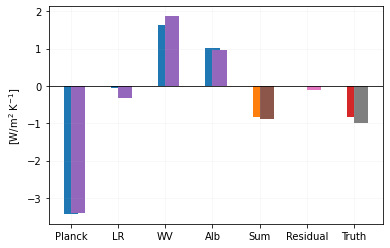

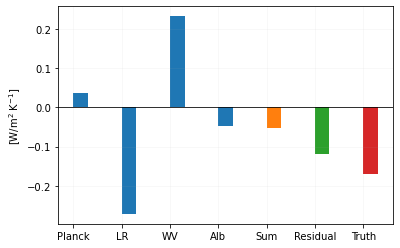

In [56]:
xlab = ['Planck','LR','WV','Alb']
net_cs_model = -0.83
plt.bar(xlab, cam6_lgm_cs_stratmaskTrue,align='center',width=0.3)
plt.bar('Sum', cam6_lgm_cs_stratmaskTrue.sum(),align='center',width=0.3)
plt.bar('Residual', net_cs_model - cam6_lgm_cs_stratmaskTrue.sum(),align='center',width=0.3)
plt.bar('Truth', net_cs_model, align='center',width=0.3)

net_cs_model = -1.00
plt.bar(xlab, cam6_2x_cs_stratmaskTrue,align='edge',width=0.3)
plt.bar('Sum', cam6_2x_cs_stratmaskTrue.sum(),align='edge',width=0.3)
plt.bar('Residual', net_cs_model - cam6_2x_cs_stratmaskTrue.sum(),align='edge',width=0.3)
plt.bar('Truth', net_cs_model, align='edge',width=0.3)

plt.grid(True,alpha=0.1)
plt.axhline(0,c='k',lw=0.8)
plt.ylabel('[W/m$^2$ K$^{-1}$]')
plt.show()


plt.bar(xlab, cam6_2x_cs_stratmaskTrue - cam6_lgm_cs_stratmaskTrue,align='edge',width=0.3)
plt.bar('Sum', cam6_2x_cs_stratmaskTrue.sum() - cam6_lgm_cs_stratmaskTrue.sum(),align='edge',width=0.3)
plt.bar('Residual', 
        (-1.00 - cam6_2x_cs_stratmaskTrue.sum()) - (
            -0.83 - cam6_lgm_cs_stratmaskTrue.sum()),align='edge',width=0.3)
plt.bar('Truth', -1.00 + .83, align='edge',width=0.3)

plt.grid(True,alpha=0.1)
plt.axhline(0,c='k',lw=0.8)
plt.ylabel('[W/m$^2$ K$^{-1}$]')
plt.show()

In [57]:
(-1.00 - cam6_2x_cs_stratmaskTrue.sum()) - (-0.83 - cam6_lgm_cs_stratmaskTrue)

array([-2.70697497,  0.66060195,  2.3522111 ,  1.73226236])

## Maps

In [ ]:
allmaps=xr.merge([dts, 
             -(dLW_planck.sum(dim='plev') + dLW_ts).rename('planck'),
             -dLW_lapserate.sum(dim='plev').rename('lapserate'),
              (-dLW_q + dSW_q).rename('watervapor'),
              dSW_alb.rename('albedo'),
             -dLW_cloud.rename('cloudLW'),
              dSW_cloud.rename('cloudSW')
             ])

allmaps['weights'] = (['lat','lon'], weight)
allmaps = allmaps.set_coords('weights')
temp = allmaps.mean(dim='time')

temp_gmean = (temp * temp.weights).sum() 
temp_gmean = temp_gmean/temp_gmean.ts
temp_gmean.drop('ts').to_array().sum()

In [124]:
allmaps

<xarray.Dataset>
Dimensions:     (time: 12, lon: 288, lat: 192)
Coordinates:
  * time        (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lon         (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat         (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    weights     (lat, lon) float64 5.871e-08 5.871e-08 ... 5.871e-08 5.871e-08
Data variables:
    ts          (time, lat, lon) float64 -5.973 -5.97 -5.968 ... -18.33 -18.33
    planck      (time, lat, lon) float64 17.49 17.56 17.56 ... 49.9 49.9 49.9
    lapserate   (time, lat, lon) float64 -4.946 -4.939 -4.936 ... -19.42 -19.42
    watervapor  (time, lat, lon) float64 -4.248 -4.252 ... -0.9781 -0.9786
    albedo      (time, lat, lon) float64 1.12 1.135 1.151 1.155 ... 0.0 0.0 0.0
    cloudLW     (time, lat, lon) float64 -1.848 -1.833 -1.821 ... -3.485 -3.485
    cloudSW     (time, lat, lon) float64 2.923 2.922 2.92 2.92 ... 0.0 0.0 0.0

In [58]:
# DONE
# cam4_dSW_cloud_lgm = copy.deepcopy(dSW_cloud)
# cam4_dts_lgm = copy.deepcopy(dts_globalmean)

In [59]:
# # DONE
# cam4_dSW_cloud_2x = copy.deepcopy(dSW_cloud)
# cam4_dts_2x = copy.deepcopy(dts_globalmean)

In [60]:
#DONE
# cam5_dSW_cloud_lgm = copy.deepcopy(dSW_cloud)
# cam5_dts_lgm = copy.deepcopy(dts_globalmean)

In [61]:
# ## DONE
# cam5_dSW_cloud_2x = copy.deepcopy(dSW_cloud)
# cam5_dts_2x = copy.deepcopy(dts_globalmean)

In [62]:
# # DONE 
# cam6_dSW_cloud_lgm = copy.deepcopy(dSW_cloud)
# cam6_dts_lgm = copy.deepcopy(dts_globalmean)

In [63]:
# # Done
# cam6_dSW_cloud_2x = copy.deepcopy(dSW_cloud)
# cam6_dts_2x = copy.deepcopy(dts_globalmean)

In [64]:
## 0p5

In [65]:
# #DONE
# cam4_dSW_cloud_lgm05 = copy.deepcopy(dSW_cloud)
# cam4_dts_lgm05 = copy.deepcopy(dts_globalmean)

In [66]:
# # DONE
# cam4_dSW_cloud_2x05 = copy.deepcopy(dSW_cloud)
# cam4_dts_2x05 = copy.deepcopy(dts_globalmean)

In [67]:
# #DONE
# cam5_dSW_cloud_lgm05 = copy.deepcopy(dSW_cloud)
# cam5_dts_lgm05 = copy.deepcopy(dts_globalmean)

In [68]:
# ## DONE
# cam5_dSW_cloud_2x05 = copy.deepcopy(dSW_cloud)
# cam5_dts_2x05 = copy.deepcopy(dts_globalmean)

In [69]:
# # DONE 
# cam6_dSW_cloud_lgm05 = copy.deepcopy(dSW_cloud)
# cam6_dts_lgm05 = copy.deepcopy(dts_globalmean)

In [70]:
# # Done
# cam6_dSW_cloud_2x05 = copy.deepcopy(dSW_cloud)
# cam6_dts_2x05 = copy.deepcopy(dts_globalmean)

In [71]:
# ## mean of all 3
# nmods = 3
# lgm_sw_mean = (cam4_dSW_cloud_lgm.mean(dim='time')/cam4_dts_lgm + 
#                cam5_dSW_cloud_lgm.mean(dim='time')/cam5_dts_lgm + 
#                cam6_dSW_cloud_lgm.mean(dim='time')/cam6_dts_lgm)/nmods

# co2_sw_mean = (cam4_dSW_cloud_2x.mean(dim='time')/cam4_dts_2x + 
#                cam5_dSW_cloud_2x.mean(dim='time')/cam5_dts_2x + 
#                cam6_dSW_cloud_2x.mean(dim='time')/cam6_dts_2x)/nmods

In [72]:
# ## mean of all 3
# nmods = 3
# lgm05_sw_mean = (cam4_dSW_cloud_lgm05.mean(dim='time')/cam4_dts_lgm05 + 
#                cam5_dSW_cloud_lgm05.mean(dim='time')/cam5_dts_lgm05 + 
#                cam6_dSW_cloud_lgm05.mean(dim='time')/cam6_dts_lgm05)/nmods

# co205_sw_mean = (cam4_dSW_cloud_2x05.mean(dim='time')/cam4_dts_2x05 + 
#                cam5_dSW_cloud_2x05.mean(dim='time')/cam5_dts_2x05 + 
#                cam6_dSW_cloud_2x05.mean(dim='time')/cam6_dts_2x05)/nmods

In [73]:
# ## save
# spath  = './archive/'
# sname = 'lgm05_sw_mean.nc'
# lgm05_sw_mean.to_netcdf(path + sname)
# sname = 'co205_sw_mean.nc'
# co205_sw_mean.to_netcdf(path + sname)
# print('finished saving')

# sname = 'lgm_sw_mean.nc'
# lgm_sw_mean.to_netcdf(path + sname)
# sname = 'co2_sw_mean.nc'
# co2_sw_mean.to_netcdf(path + sname)
# print('finished saving')

NameError: name 'cam5_dSW_cloud_2x' is not defined

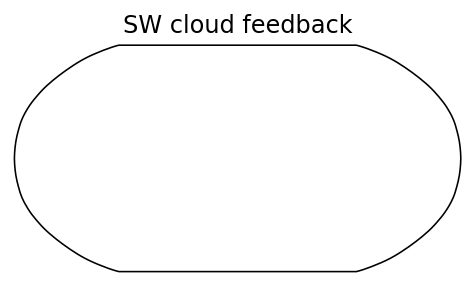

In [74]:
## Feedback Maps
plotvar2= 'RESTOM'
plotvar = 'TREFHT'

## normalized by SST
coastwid = 0.4
nlevs = 6*4 ## must be even
vabs = 12 #0.0008
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('bwr', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(4,2.2), dpi=72*2, #layout='constrained',
                      # subplot_kw={'projection':ccrs.Orthographic(central_longitude=180,central_latitude=15)})
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=-180)},
                      gridspec_kw={'wspace': 0.02, 'hspace': 0.02})

axtemp = ax#[0,0]
plt.sca(axtemp)

plt.title('SW cloud feedback')
 
ds = cam5_dSW_cloud_2x.mean(dim='time')
gmean = cam5_dts_2x
ds = ds/gmean.values

## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

cs = plt.contourf(wrap_lon,ds.lat,
               wrap_ds.data,cmap=cmap,levels=levs,extend='both',
               vmin=-vabs,vmax=vabs,
               transform=ccrs.PlateCarree())#,zorder=3)

plt.colorbar(cs,label='$\lambda^{SW}_{Cloud}$ [W m$^{-2}$ K$^{-1}$]',
            ticks = np.arange(-vabs,vabs+.1,4))
             
axtemp.set_global()
axtemp.coastlines(color='k',zorder=1,lw=coastwid)
glc = 'lightgrey'
glw = 0#0.5
gls = '-'
gla= 0#0.5
gl = axtemp.gridlines(color=glc, lw=glw, linestyle=gls, draw_labels=True, alpha=gla)
gl.left_labels = True
gl.right_labels = gl.bottom_labels = gl.top_labels = False
gl.xlines = False
gl.ylabel_style = {'size': 'x-small', 'color': '0.2'}

plt.show()


In [ ]:
## Feedback Maps
plotvar2= 'RESTOM'
plotvar = 'TREFHT'

## normalized by SST
coastwid = 0.4
nlevs = 6*4 ## must be even
vabs = 12 #0.0008
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('bwr', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(4,2.2), dpi=72*3, #layout='constrained',
                      # subplot_kw={'projection':ccrs.Orthographic(central_longitude=180,central_latitude=15)})
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=-180)},
                      gridspec_kw={'wspace': 0.02, 'hspace': 0.02})

axtemp = ax#[0,0]
plt.sca(axtemp)

plt.title('SW cloud feedback')
 
ds = lgm_sw_mean

## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

cs = plt.contourf(wrap_lon,ds.lat,
               wrap_ds.data,cmap=cmap,levels=levs,extend='both',
               vmin=-vabs,vmax=vabs,
               transform=ccrs.PlateCarree())#,zorder=3)

plt.colorbar(cs,label='[W m$^{-2}$ K$^{-1}$]', #$\lambda^{SW}_{Cloud}$ 
            ticks = np.arange(-vabs,vabs+.1,4), pad=0.02, shrink=0.8)
             
axtemp.set_global()
axtemp.coastlines(color='k',zorder=1,lw=coastwid)
glc = 'lightgrey'
glw = 0#0.5
gls = '-'
gla= 0#0.5
gl = axtemp.gridlines(color=glc, lw=glw, linestyle=gls, draw_labels=True, alpha=gla)
gl.left_labels = True
gl.right_labels = gl.bottom_labels = gl.top_labels = False
gl.xlines = False
gl.ylabel_style = {'size': 'x-small', 'color': '0.2'}

plt.show()


In [ ]:
## Feedback Maps
plotvar2= 'RESTOM'
plotvar = 'TREFHT'

## normalized by SST
coastwid = 0.4
nlevs = 6*4 ## must be even
vabs = 12 #0.0008
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('bwr', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(4,2.2), dpi=72*3, #layout='constrained',
                      # subplot_kw={'projection':ccrs.Orthographic(central_longitude=180,central_latitude=15)})
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=-180)},
                      gridspec_kw={'wspace': 0.02, 'hspace': 0.02})

axtemp = ax#[0,0]
plt.sca(axtemp)

plt.title('SW cloud feedback')
 
ds = co2_sw_mean

## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

cs = plt.contourf(wrap_lon,ds.lat,
               wrap_ds.data,cmap=cmap,levels=levs,extend='both',
               vmin=-vabs,vmax=vabs,
               transform=ccrs.PlateCarree())#,zorder=3)

plt.colorbar(cs,label='[W m$^{-2}$ K$^{-1}$]', #$\lambda^{SW}_{Cloud}$ 
            ticks = np.arange(-vabs,vabs+.1,4), pad=0.02, shrink=0.8)
             
axtemp.set_global()
axtemp.coastlines(color='k',zorder=1,lw=coastwid)
glc = 'lightgrey'
glw = 0#0.5
gls = '-'
gla= 0#0.5
gl = axtemp.gridlines(color=glc, lw=glw, linestyle=gls, draw_labels=True, alpha=gla)
gl.left_labels = True
gl.right_labels = gl.bottom_labels = gl.top_labels = False
gl.xlines = False
gl.ylabel_style = {'size': 'x-small', 'color': '0.2'}

plt.show()


In [ ]:
## Feedback Maps
plotvar2= 'RESTOM'
plotvar = 'TREFHT'

## normalized by SST
coastwid = 0.4
nlevs = 6*4 ## must be even
vabs = 12 #0.0008
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('bwr', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(4,2.2), dpi=72*2, #layout='constrained',
                      # subplot_kw={'projection':ccrs.Orthographic(central_longitude=180,central_latitude=15)})
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=-180)},
                      gridspec_kw={'wspace': 0.02, 'hspace': 0.02})

axtemp = ax#[0,0]
plt.sca(axtemp)

plt.title('SW cloud feedback')
 
ds = co2_sw_mean - lgm_sw_mean

## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

cs = plt.contourf(wrap_lon,ds.lat,
               wrap_ds.data,cmap=cmap,levels=levs,extend='both',
               vmin=-vabs,vmax=vabs,
               transform=ccrs.PlateCarree())#,zorder=3)

plt.colorbar(cs,label='$\lambda^{SW}_{Cloud}$ [W m$^{-2}$ K$^{-1}$]',
            ticks = np.arange(-vabs,vabs+.1,5), pad=0.02, shrink=0.8)
             
axtemp.set_global()
axtemp.coastlines(color='k',zorder=1,lw=coastwid)
glc = 'lightgrey'
glw = 0#0.5
gls = '-'
gla= 0#0.5
gl = axtemp.gridlines(color=glc, lw=glw, linestyle=gls, draw_labels=True, alpha=gla)
gl.left_labels = True
gl.right_labels = gl.bottom_labels = gl.top_labels = False
gl.xlines = False
gl.ylabel_style = {'size': 'x-small', 'color': '0.2'}

plt.show()

In [ ]:
yy = ds.groupby('lat').mean(dim='lon')
xx = np.sin(np.deg2rad(yy.lat))
plt.plot(xx,yy)
plt.xticks(ticks=[-1,3**0.5 / -2,-0.5,0,0.5,3**0.5 / 2,1],labels=['90S','60S','30S','EQ','30N','60N','90N'])
plt.axhline(0)

In [ ]:
print((yy * weight.sum(axis=1)).sum())
plt.plot(xx,(yy * weight.sum(axis=1)).cumsum() / ((yy * weight.sum(axis=1)).sum()))
plt.xticks(ticks=[-1,-0.5,0,0.5,1],labels=['90S','30S','EQ','30N','90N'])
plt.show()

In [ ]:
## Feedback Maps
plotvar2= 'RESTOM'
plotvar = 'TREFHT'

## normalized by SST
coastwid = 0.4
nlevs = 6*3 ## must be even
vabs = 12 #0.0008
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('bwr', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(4,2.2), dpi=72*3, #layout='constrained',
                      # subplot_kw={'projection':ccrs.Orthographic(central_longitude=180,central_latitude=15)})
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=-180)},
                      gridspec_kw={'wspace': 0.02, 'hspace': 0.02})

axtemp = ax#[0,0]
plt.sca(axtemp)

plt.title('SW cloud feedback')
 
ds = lgm05_sw_mean

## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

cs = plt.contourf(wrap_lon,ds.lat,
               wrap_ds.data,cmap=cmap,levels=levs,extend='both',
               vmin=-vabs,vmax=vabs,
               transform=ccrs.PlateCarree())#,zorder=3)

plt.colorbar(cs,label='[W m$^{-2}$ K$^{-1}$]', #$\lambda^{SW}_{Cloud}$ 
            ticks = np.arange(-vabs,vabs+.1,4), pad=0.02, shrink=0.8)
             
axtemp.set_global()
axtemp.coastlines(color='k',zorder=1,lw=coastwid)
glc = 'lightgrey'
glw = 0#0.5
gls = '-'
gla= 0#0.5
gl = axtemp.gridlines(color=glc, lw=glw, linestyle=gls, draw_labels=True, alpha=gla)
gl.left_labels = True
gl.right_labels = gl.bottom_labels = gl.top_labels = False
gl.xlines = False
gl.ylabel_style = {'size': 'x-small', 'color': '0.2'}

plt.show()


In [ ]:
## Feedback Maps
plotvar2= 'RESTOM'
plotvar = 'TREFHT'

## normalized by SST
coastwid = 0.4
nlevs = 6*3 ## must be even
vabs = 12 #0.0008
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('bwr', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(4,2.2), dpi=72*3, #layout='constrained',
                      # subplot_kw={'projection':ccrs.Orthographic(central_longitude=180,central_latitude=15)})
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=-180)},
                      gridspec_kw={'wspace': 0.02, 'hspace': 0.02})

axtemp = ax#[0,0]
plt.sca(axtemp)

plt.title('SW cloud feedback')
 
ds = co205_sw_mean

## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

cs = plt.contourf(wrap_lon,ds.lat,
               wrap_ds.data,cmap=cmap,levels=levs,extend='both',
               vmin=-vabs,vmax=vabs,
               transform=ccrs.PlateCarree())#,zorder=3)

plt.colorbar(cs,label='[W m$^{-2}$ K$^{-1}$]', #$\lambda^{SW}_{Cloud}$ 
            ticks = np.arange(-vabs,vabs+.1,4), pad=0.02, shrink=0.8)
             
axtemp.set_global()
axtemp.coastlines(color='k',zorder=1,lw=coastwid)
glc = 'lightgrey'
glw = 0#0.5
gls = '-'
gla= 0#0.5
gl = axtemp.gridlines(color=glc, lw=glw, linestyle=gls, draw_labels=True, alpha=gla)
gl.left_labels = True
gl.right_labels = gl.bottom_labels = gl.top_labels = False
gl.xlines = False
gl.ylabel_style = {'size': 'x-small', 'color': '0.2'}

plt.show()


In [4]:
albk = xr.open_dataset('./kernels/alb.kernel.nc').mean(dim='time')

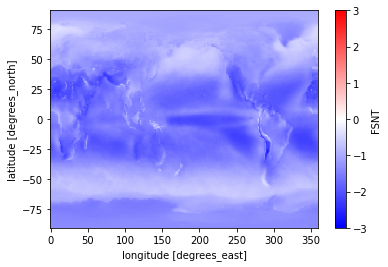

In [19]:
albk.FSNT.plot(cmap='bwr',vmin=-3,vmax=3)
# albk.FSNT.plot.contourf(cmap='bwr',vmin=-2,vmax=2,levels=20)

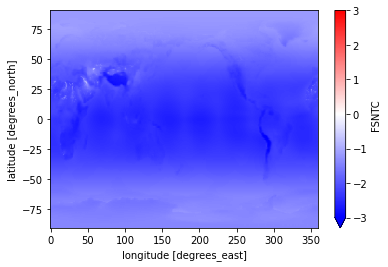

In [20]:
# albk.FSNTC.plot.contourf(cmap='bwr',vmin=-5,vmax=5,levels=20)
albk.FSNTC.plot(cmap='bwr',vmin=-3,vmax=3)

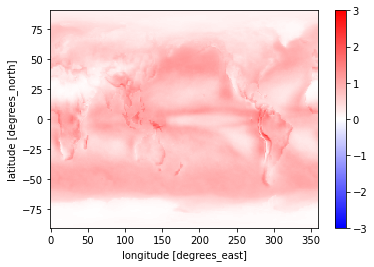

In [22]:
# (albk.FSNT - albk.FSNTC).plot.contourf(cmap='bwr',vmin=-3,vmax=3,levels=20)
(albk.FSNT - albk.FSNTC).plot(cmap='bwr',vmin=-3,vmax=3)

In [45]:
## quick albedo check
alb = xr.open_dataset('./kernels/alb.kernel.nc')

# Specify the year
year = 2000

# Generate the mid-month dates for each month
mid_month_dates = [pd.Timestamp(year, month, 15) for month in range(1, 13)]

# Convert the dates to a pandas DatetimeIndex
datetime_index = pd.DatetimeIndex(mid_month_dates)

alb['time'] = mid_month_dates

In [ ]:
landf

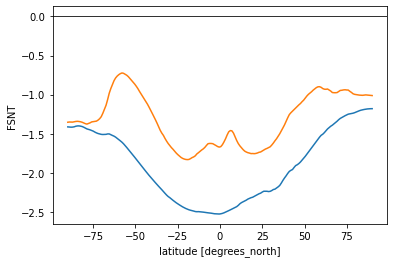

In [46]:
alb.mean(dim='time').FSNTC.mean(dim='lon').plot()
alb.mean(dim='time').FSNT.mean(dim='lon').plot()
plt.axhline(0, c='k',lw=0.8)
plt.show()

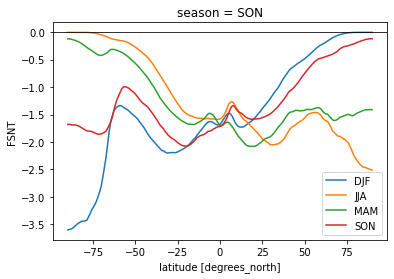

In [44]:
for i,da in enumerate(alb.groupby('time.season').mean(dim='time').FSNT):
    da.mean(dim='lon').plot(label=da.season.values)
plt.legend()
plt.axhline(0, c='k',lw=0.8)
plt.show()

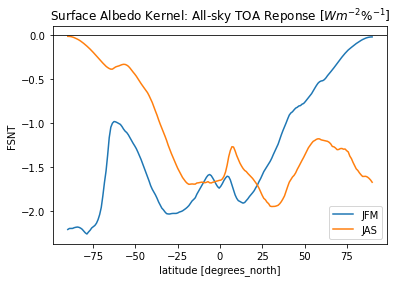

In [60]:
alb.FSNT.isel(time=slice(0,3)).mean(dim=['time', 'lon']).plot(label='JFM')
alb.FSNT.isel(time=slice(6,6+3)).mean(dim=['time', 'lon']).plot(label='JAS')

plt.title('Surface Albedo Kernel: All-sky TOA Reponse $[W m^{-2} \%^{-1}]$')
plt.legend()
plt.axhline(0, c='k',lw=0.8)
plt.show()

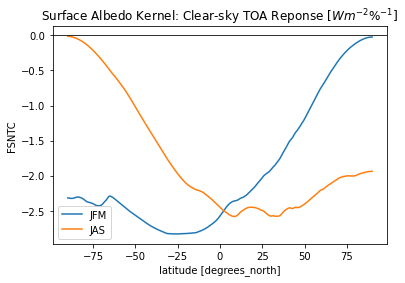

In [59]:
alb.FSNTC.isel(time=slice(0,3)).mean(dim=['time', 'lon']).plot(label='JFM')
alb.FSNTC.isel(time=slice(6,6+3)).mean(dim=['time', 'lon']).plot(label='JAS')

plt.title('Surface Albedo Kernel: Clear-sky TOA Reponse $[W m^{-2} \%^{-1}]$')
plt.legend()
plt.axhline(0, c='k',lw=0.8)
plt.show()

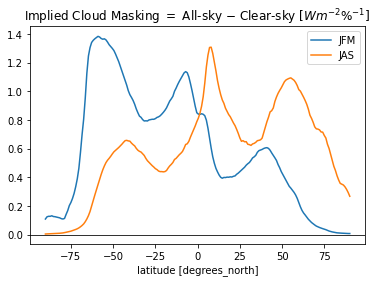

In [62]:
(alb.FSNT.isel(time=slice(0,3)) - alb.FSNTC.isel(time=slice(0,3))).mean(dim=['time', 'lon']).plot(label='JFM')
(alb.FSNT.isel(time=slice(6,6+3)) - alb.FSNTC.isel(time=slice(6,6+3))).mean(dim=['time', 'lon']).plot(label='JAS')

plt.title('Implied Cloud Masking $=$ All-sky $-$ Clear-sky $[W m^{-2} \%^{-1}]$')
plt.legend()
plt.axhline(0, c='k',lw=0.8)
plt.show()